<b> Functions <b>

In [1]:
from qutip import *
import pylab as py
import numpy as np
import matplotlib.pyplot as plt


def heaviside(x):
    if x >= 0 :
        return 1
    if x < 0 :
        return 0
    
def nega(rho, subsys):
    
    #create mask which counts the number of possible subsystems
    x = [0 for i in rho.dims[0]]
   
    #assigns a 1 in the position of the subsystem for which we want to compute the negativity
    x[subsys] = 1
        
    #takes partial transpose with respect to subsys x
    rho_pt = partial_transpose(rho, x)
    
    #finds eivenvalues of pt matrix
    eig = rho_pt.eigenenergies()
    
    #finds abs value of the eigenvalues
    abs_eig = abs(eig)
    
    negat = 0 #initialize value of negativity
    
    #takes the difference 
    diff = (abs_eig - eig)
    
    
    #computes negativity
    for el in diff:
        negat += el
    
    return negat

<b> Parameters <b>

In [2]:
#INPUT TUNABLE PARAMETER:
# coupling switching frequency = 'fs'
# frequency of cavity photons = 'ph'
# photon's dissipation rates = 'diss'

ti = 0
tf = 2*10**(-9)
steps = 2000
tau_list = np.linspace(ti,tf,steps)
steps_an = 2000
tau_list_an = np.linspace(ti,tf,steps_an)


# CYCLES FOR FREQUENCY SCAN
cycles = 1 # number of variations of parameters
pi = 1
pf = 1
par_list = np.linspace(pi,pf,cycles)
par_range = [0 for i in range(cycles)]


[1.]
1e-12


<b> Numerical solution <b>

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


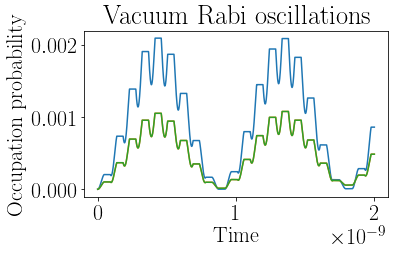

0
9.192866335723479e-11


In [50]:
exp_cav_num = np.zeros([cycles, steps])
exp_qub1_num = np.zeros([cycles, steps])
exp_qub2_num = np.zeros([cycles, steps])

cont = 0

for j in range(0, cycles):


    #transition frequency
    wc = 10**(9)*2*np.pi*4.343  # frequency of the cavity photons
    wa = 10**(9)*2*np.pi*5.439  # transition frequency of the qubits
    wd = 2*(wa)*par_list[j] #frequency of switching of coupling

    par_range[j] = wd

    N = 2      # number of cavity fock states (N-1 photons inn the cavity)
    n_th_a = 0.0           # temperature in frequency units
    g = 10**(6)*2*np.pi*50 # coupling strength





    # intial state (ground state)
    psi0 = tensor(basis(N,0), basis(2,0), basis(2,0))    # start with 0 excited atom and 0 photons



    # density matrix
    rho0 = ket2dm(psi0) #turns ket into a density matrix




    # operators
    a  = tensor(destroy(N), qeye(2), qeye(2)) #destroy cavity photon
    sm1 = tensor(qeye(N), destroy(2), qeye(2)) #destroy atom1 excitation
    sm2 = tensor(qeye(N), qeye(2), destroy(2)) #destroy atom2 excitation


    #list of collapse operator (dissipation ops) for separate baths (for Lindblad's equation)    
    c_op_list = []

    



    # Rabi model Hamiltonian for two atoms and a cavity mode for time dependent coupling

    def H1_coeff(t,args):
        coeff = g*heaviside(np.cos((wd)*t+3/2*np.pi))
        return coeff

    H0 = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2

    H1 = (a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag() + a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag())


    H = [H0,[H1,H1_coeff]]





    #solve master equation
    output = mesolve(H, rho0, tau_list, c_op_list ,[a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2])  #stores expectation values of number of phontons, excitation of atom 1 and 2 
    

#   plot excitation probabilities of photons and atoms
    plt.plot(tau_list, output.expect[0], label="Cavity")
    plt.plot(tau_list, output.expect[1], label="Atom 1 excited state")
    plt.plot(tau_list, output.expect[2], label="Atom 2 excited state")
#   plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Occupation probability')
    plt.title('Vacuum Rabi oscillations');
    plt.show()

    exp_cav_num[j][:] = output.expect[0]
    exp_qub1_num[j][:] = output.expect[1]
    exp_qub2_num[j][:] = output.expect[2]
        


    #SAVE DATA
    np.save('data/exp_cav_num%s'%j, exp_cav_num[j][:])
    np.save('data/exp_qub1_num%s'%j, exp_qub1_num[j][:])
    np.save('data/exp_qub2_num%s'%j, exp_qub2_num[j][:])


<b> Analytical solution <b>

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


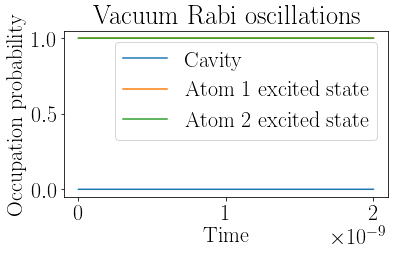

0


In [51]:
cont = 0

exp_cav_an = np.zeros([cycles, steps_an])

exp_qub1_an = np.zeros([cycles, steps_an])

exp_qub2_an = np.zeros([cycles, steps_an])


for j in range(0, cycles):

    cont = 0
    
    wd = 2*(wa)*par_list[j] #frequency of switching of coupling

    par_range[j] = wd
    
    T=2*np.pi/(wd)
    
    for t in tau_list_an:


        #components of wavefunction
        a11 = -g/(2*(wc+wa))*(1 - (2*np.exp(-complex(0,1)*(wc+wa)*t))/(1+np.exp(complex(0,1)*(wc+wa)*T/2)) )
        a12 = a11
        a21 = (g**2*(2*np.exp(-complex(0,1)*t*(wa + wc)) + complex(0,1)*(2*t + T)*(wa + wc) - 2*(1/(np.cos((T/4*(wa + wc)))))**2 - (2*complex(0,1))*(1 + np.exp((-complex(0,1))*t*(wa + wc)))*np.tan((T*(wa + wc))/4)))/(4*(wa + wc)**2)

        b0 = 1/(wa**2 + wa*wc)
        b1 = 2*complex(0,1)*np.exp(-complex(0,1)*t*(wa+wc))*(complex(0,1) + np.tan(T/4*(wa+wc)))/(wa**2 - wc**2)
        b2 = np.exp(-2*complex(0,1)*t*wa)*(wa+wc)/(wa*(wa-wc)*(wa+wc))
        b3 = np.exp(-2*complex(0,1)*t*wa)*(-2*complex(0,1)*wc*np.tan(T*wa/2))/(wa*(wa-wc)*(wa+wc))
        b4 = np.exp(-2*complex(0,1)*t*wa)*( 2*wa*np.tan(T*(wc-wa)/4)*(complex(0,1)+np.tan(T*(wa+wc)/4))  )/(wa*(wa-wc)*(wa+wc))

        a22 = (g**2)/4*(b0+b1+b2+b3+b4)  

        #state found analytically
        psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0)) + (a11)*tensor(basis(N,1), basis(2,1), basis(2,0)) + (a12)*tensor(basis(N,1), basis(2,0), basis(2,1)) + a21*tensor(basis(N,0), basis(2,0), basis(2,0)) + a22*tensor(basis(N,0), basis(2,1), basis(2,1)) 
        psi0_an = psi0_an.unit()
    

        #density matrix
        rho0_an = ket2dm(psi0_an)

        exp_cav_an[j][cont] = expect(a.dag() * a, rho0_an)
    
        exp_qub1_an[j][cont] = expect(sm1.dag() * sm1, rho0_an)

        exp_qub2_an[j][cont] = expect(sm2.dag() * sm2, rho0_an)

        cont += 1
        
    #plot excitation probabilities of photons and atoms
    plt.plot(tau_list_an, exp_cav_an[j][:], label="Cavity")
    plt.plot(tau_list_an, exp_qub1_an[j][:], label="Atom 1 excited state")
    plt.plot(tau_list_an,  exp_qub2_an[j][:], label="Atom 2 excited state")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Occupation probability')
    plt.title('Vacuum Rabi oscillations');
    plt.show()
    
    #SAVE DATA
    np.save('data/exp_cav_num%s'%j, exp_cav_an[j][:])
    np.save('data/exp_qub1_num%s'%j, exp_qub1_an[j][:])
    np.save('data/exp_qub2_num%s'%j, exp_qub2_an[j][:])
    
    print(j)
    





<b> Plot dependence on parameters

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


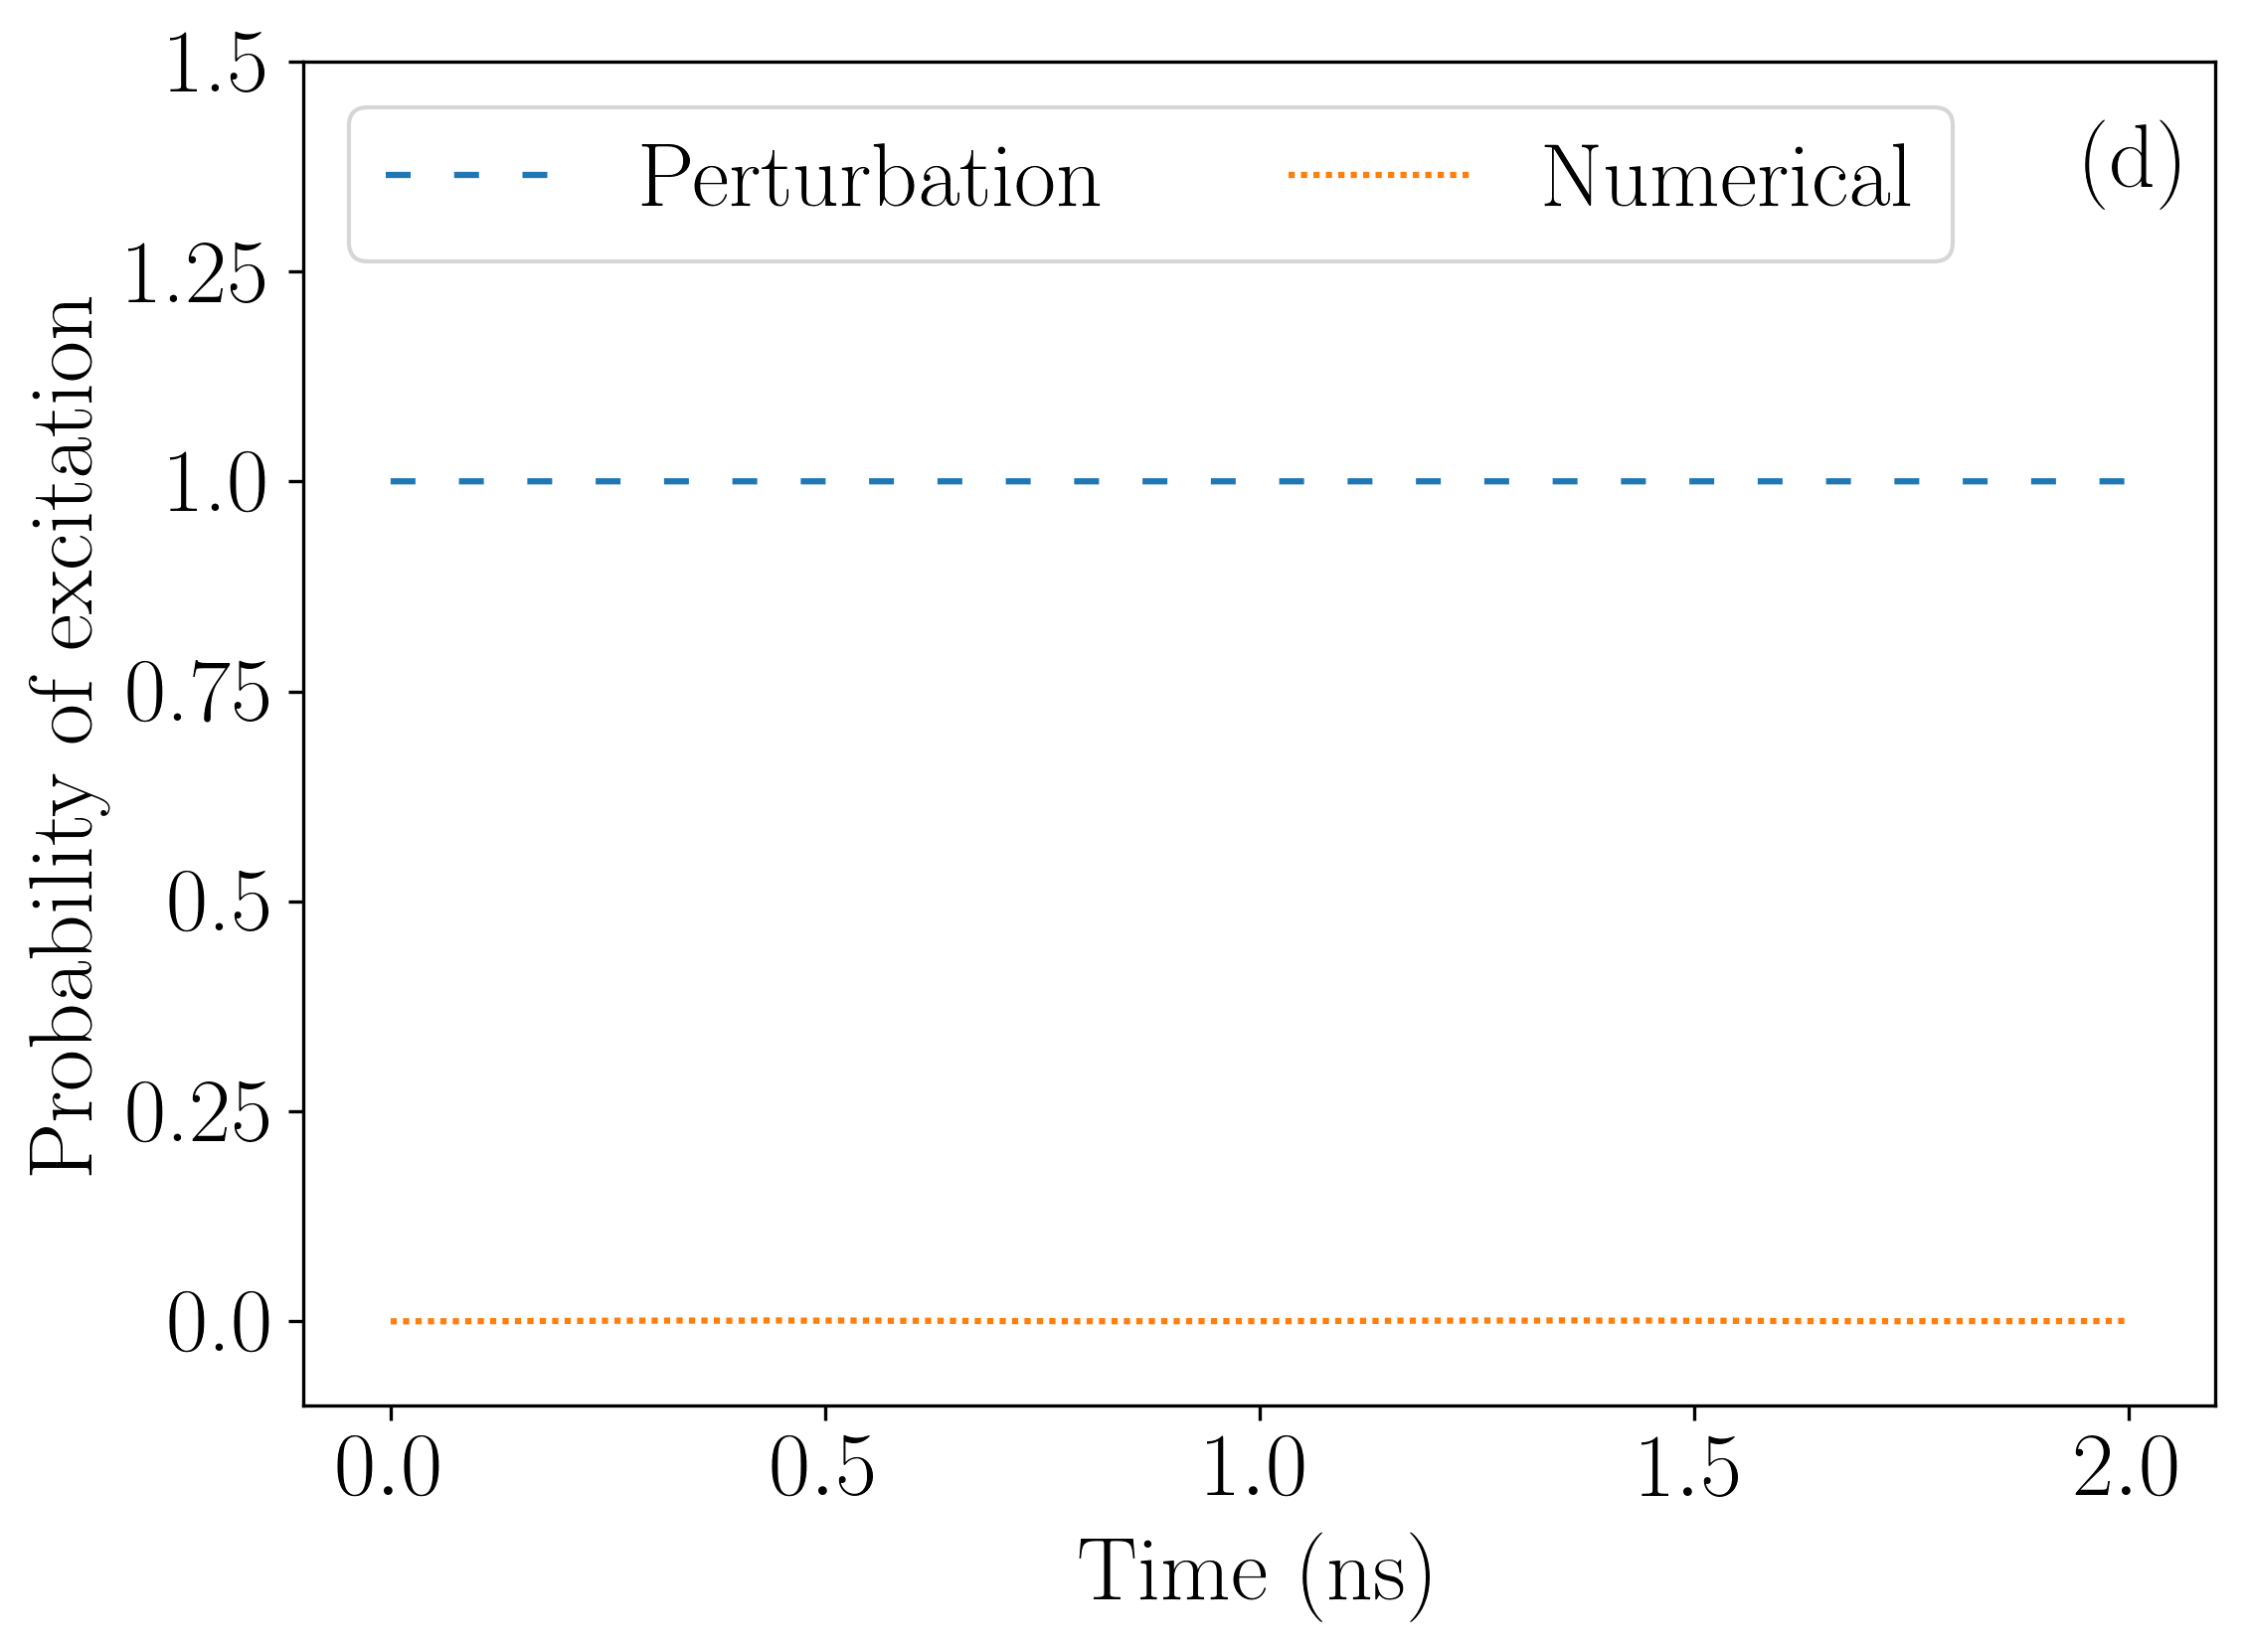

In [54]:
#changes plot parameters
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'figure.autolayout': True})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# x = np.linspace(0.0001, 0.014, 100)

# #LOAD DATA
# if tune == 'fs':
#     c = np.load('data/conc_2q_fs.npy')
#     c_an = np.load('data/conc_an_2q_fs.npy')
#     n = np.load('data/neg_2q_fs.npy')
#     n_an = np.load('data/neg_an_2q_fs.npy')

if cycles>1:

    ylab = r'Frequency of coupling switching (GHz)'

    #numerical
    plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
    plt.contourf(tau_list*10**9,par_range,exp_qub1_num, 100)
    plt.xlabel(r' Time (ns)', fontsize = 22)
    plt.ylabel(r'Frequency of coupling switching (GHz)', fontsize = 22)
    plt.colorbar()  # draw colorbar
    plt.title('Probability of excitation')
    plt.savefig('p_ex_qub1_num.eps', dpi = 300)
    plt.show()

    #analytical
    plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
    plt.contourf(tau_list_an*10**9,par_range,exp_qub1_an, 100)
    plt.xlabel(r' Time (ns)', fontsize = 22)
    plt.ylabel(ylab, fontsize = 22)
    plt.colorbar()  # draw colorbar
    plt.title('Probability of excitation')
    plt.savefig('p_ex_qub1_an.eps', dpi = 300)
    plt.show()

if cycles==1:
    
    plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
    plt.plot(tau_list*10**9, exp_qub1_an[0],dashes=[4, 7], label = 'Perturbation')
    plt.plot(tau_list*10**9, exp_qub1_num[0],dashes=[1, 1], label = 'Numerical')
    plt.xlabel(r' Time (ns)', fontsize = 22 )
    plt.ylabel(r' Probability of excitation', fontsize = 22)   
    plt.legend(loc=2,ncol=2)
    ymin = -0.1*max(exp_qub1_an[0])
    ymax = max(2*exp_qub1_an[0])-0.6*max(exp_qub1_an[0])
    

    plt.ylim((ymin,ymax)) # sets limit for y-axis

    locs, labels = plt.yticks()
    labels = [str(round(e,4)) for e in locs if e >= 0]#locs
    locs = [e for e in locs if e>=0]
    plt.yticks(locs, labels)
    
    plt.text(1.95, 1.35, r'(d)')

    plt.savefig('exp_qub1_num_an.eps', dpi = 300)
    plt.show()
    
